In [1]:
# 1. 파이썬 코드에서 Matplotlib 폰트 설정
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from datetime import timedelta
from itertools import combinations
from collections import Counter

# 폰트 설정
plt.rc('font', family='Malgun Gothic')
# 마이너스 부호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

print("한글 폰트 설정이 완료되었습니다.")


한글 폰트 설정이 완료되었습니다.


In [2]:
# 3. 데이터 로드 및 통합 (모든 문제 풀이의 시작점)
# dataframe 확인해라!
try:
    orders_df = pd.read_csv('../data/orders.csv')
    payments_df = pd.read_csv('../data/payments.csv')
    products_df = pd.read_csv('../data/products.csv')
    shipping_df = pd.read_csv('../data/shipping.csv')
    customers_df = pd.read_csv('../data/customers.csv')

    # 모든 데이터프레임 병합
    df = pd.merge(orders_df, payments_df, on='order_id', how='left')
    df = pd.merge(df, products_df, on='product_id', how='left')
    df = pd.merge(df, customers_df, on='customer_id', how='left')
    df = pd.merge(df, shipping_df, on='order_id', how='left')

    # 데이터 전처리
    date_cols = ['order_date', 'payment_date', 'join_date', 'shipping_start_date', 'shipping_end_date']
    for col in date_cols:
        df[col] = pd.to_datetime(df[col], errors='coerce')
    df['total_sales'] = df['quantity'] * df['price']
    
    print("데이터 로드 및 통합이 완료되었습니다.")

except FileNotFoundError as e:
    print(f"파일을 찾을 수 없습니다: {e}")


데이터 로드 및 통합이 완료되었습니다.


In [4]:
# 문제 7: 고객의 첫 구매 상품과 두 번째 구매 상품 카테고리 간의 전환 패턴을 분석하세요.
# 시각화: 히트맵 (검색해야 함)

# 비즈니스 목적: 고객의 구매 여정을 이해하고, 첫 구매 상품에 따라 다음 구매를 유도할 상품 추천 전략을 수립합니다.
df.columns

Index(['order_id', 'customer_id', 'product_id', 'order_date', 'quantity',
       'payment_id', 'payment_method', 'payment_status', 'payment_date',
       'product_name', 'category', 'price', 'stock', 'name', 'gender', 'age',
       'join_date', 'city', 'shipping_id', 'shipping_company',
       'shipping_status', 'shipping_start_date', 'shipping_end_date',
       'total_sales'],
      dtype='object')

###### 출력 결과를 보고 코딩하세요
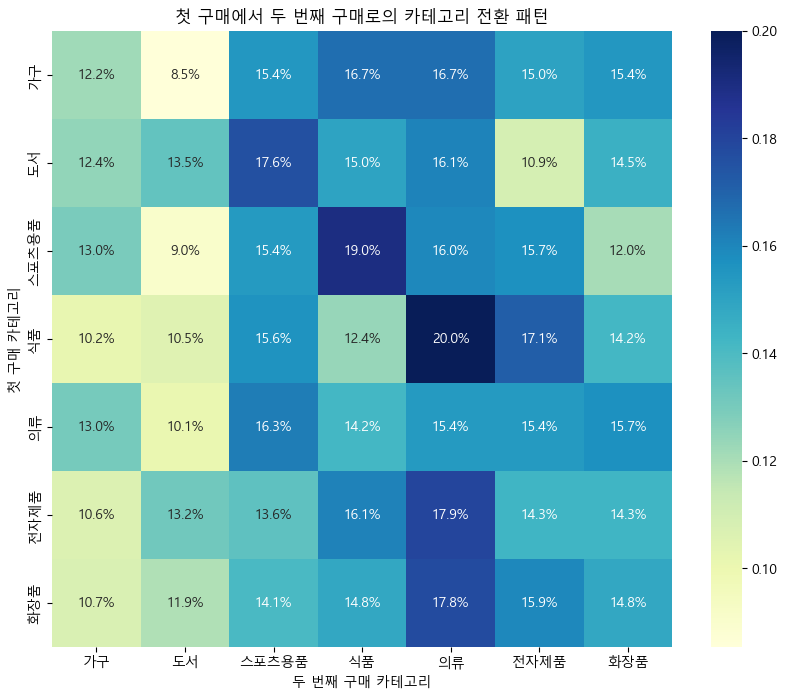

In [ ]:
# 원 데이터에서 고객아이디, 주문일자, 카테고리만 가져와서 고객아이디와 주문일로 그룹핑하고  정렬
# 그리고 나서 각 고객별로 cumcount()로 주문순서를 구해서 구매순서 컬럼 생성해서 df_sorted DF 생성
df_sorted = (
    df[['customer_id', 'order_date', 'category']]   # 필요한 3개 컬럼만 선택
    .sort_values(by=['customer_id', 'order_date'])  # 고객별로 묶고, 구매일자 순으로 정렬
    .assign(purchase_order=lambda x: x.groupby('customer_id').cumcount() + 1)  # 각 고객의 구매 순서 번호 부여 (1부터 시작)
)
df_sorted # 검증용

,customer_id,order_date,category,purchase_order
1022,C0001,2024-01-03 15:03:51,의류,1
3154,C0001,2024-06-07 00:42:31,도서,2
3415,C0001,2024-06-24 23:09:17,식품,3
3438,C0001,2024-06-26 07:54:05,스포츠용품,4
6450,C0001,2025-02-05 12:35:35,도서,5
...,...,...,...,...
3914,C2000,2024-07-31 19:40:44,도서,2
4404,C2000,2024-09-07 12:51:41,의류,3
4414,C2000,2024-09-07 22:52:43,화장품,4
7622,C2000,2025-04-29 08:39:11,화장품,5


In [38]:
# 첫 번째와 두 번째 구매만 필터링 (2회 이상 구매 고객만)
df_second_purchases = (
    df_sorted  
    .query('purchase_order <= 2')  # 구매 순서가 1 또는 2인 행만 추출
    .groupby('customer_id')  # 고객별로 그룹화
    .filter(lambda x: len(x) == 2)  # 2개의 구매 기록이 있는 고객만 선택 (1회만 구매한 고객 제외)
)
df_second_purchases # 검증용

,customer_id,order_date,category,purchase_order
1022,C0001,2024-01-03 15:03:51,의류,1
3154,C0001,2024-06-07 00:42:31,도서,2
7357,C0002,2025-04-11 22:46:32,가구,1
8605,C0002,2025-07-10 02:16:30,전자제품,2
1913,C0003,2024-03-09 12:46:59,화장품,1
...,...,...,...,...
4852,C1998,2024-10-11 01:03:59,화장품,2
1774,C1999,2024-02-26 12:35:54,화장품,1
3319,C1999,2024-06-17 00:36:40,식품,2
957,C2000,2023-12-28 17:26:11,화장품,1


In [39]:
# 피벗 테이블 생성
pivot_df = (
    df_second_purchases  # 1, 2번째 구매만 있는 데이터
    .pivot(index='customer_id', columns='purchase_order', values='category')  # 행: 고객ID, 열: 구매순서(1,2), 값: 카테고리명
    .rename(columns={1: 'first_category', 2: 'second_category'})  # 컬럼명을 1, 2에서 의미있는 이름으로 변경
)
pivot_df #검증용


purchase_order,first_category,second_category
customer_id,,
C0001,의류,도서
C0002,가구,전자제품
C0003,화장품,화장품
C0004,전자제품,의류
C0005,도서,식품
...,...,...
C1996,식품,스포츠용품
C1997,스포츠용품,가구
C1998,가구,화장품


In [40]:
# 전환 패턴 카운트 및 비율 계산
transition_counts = (
    pivot_df  # 첫번째, 두번째 카테고리가 컬럼인 데이터프레임
    .value_counts(['first_category', 'second_category'])  # 각 카테고리 조합이 몇 번 나타났는지 카운트
    .unstack(fill_value=0)  # just in case 두번째 카테고리를 컬럼으로 펼치고, 없는 값은 0으로 채움 (행렬 형태로 변환)
)
transition_counts # 검증용


second_category,가구,도서,스포츠용품,식품,의류,전자제품,화장품
first_category,,,,,,,
가구,30,21,38,41,41,37,38
도서,24,26,34,29,31,21,28
스포츠용품,43,30,51,63,53,52,40
식품,28,29,43,34,55,47,39
의류,44,34,55,48,52,52,53
전자제품,29,36,37,44,49,39,39
화장품,29,32,38,40,48,43,40


In [41]:
# 각 행(첫번째 카테고리)의 합계로 나눠서 비율 계산
transition_percent = transition_counts.div(transition_counts.sum(axis=1), axis=0)  # axis=1: 행 방향 합계, axis=0: 행 방향으로 나누기
transition_percent # 검증용

second_category,가구,도서,스포츠용품,식품,의류,전자제품,화장품
first_category,,,,,,,
가구,0.121951,0.085366,0.154472,0.166667,0.166667,0.150407,0.154472
도서,0.124352,0.134715,0.176166,0.150259,0.160622,0.108808,0.145078
스포츠용품,0.129518,0.090361,0.153614,0.189759,0.159639,0.156627,0.120482
식품,0.101818,0.105455,0.156364,0.123636,0.200000,0.170909,0.141818
의류,0.130178,0.100592,0.162722,0.142012,0.153846,0.153846,0.156805
전자제품,0.106227,0.131868,0.135531,0.161172,0.179487,0.142857,0.142857
화장품,0.107407,0.118519,0.140741,0.148148,0.177778,0.159259,0.148148


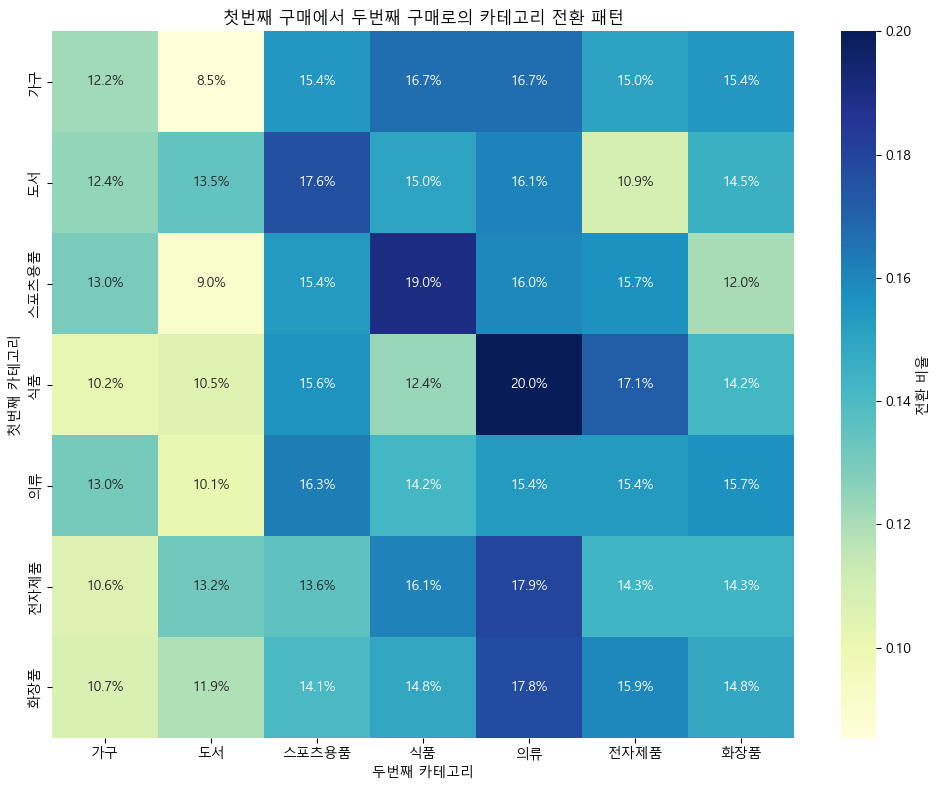

In [42]:
# 히트맵 시각화
plt.figure(figsize=(10, 8))  # 그림 크기를 가로 10인치, 세로 8인치로 설정
sns.heatmap(
    transition_percent,  # 비율 데이터를 히트맵으로 표시
    annot=True,  # 각 셀에 숫자 표시
    fmt='.1%',  # 소수점 첫째 자리까지 퍼센트 형식으로 표시 (예: 25.3%)
    cmap='YlGnBu',  # 노란색-초록색-파란색 색상 팔레트 사용
    cbar_kws={'label': '전환 비율'}  # 컬러바에 '전환 비율' 레이블 추가
)
plt.title('첫번째 구매에서 두번째 구매로의 카테고리 전환 패턴')
plt.xlabel('두번째 카테고리')
plt.ylabel('첫번째 카테고리')
plt.tight_layout()
plt.show()